In [2]:
import jax
import jax.numpy as jnp

x = jnp.arange(10)
print(x)

[0 1 2 3 4 5 6 7 8 9]


In [3]:
long_vector = jnp.arange(int(1e7))

%timeit jnp.dot(long_vector, long_vector).block_until_ready()

88 µs ± 1.11 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [4]:
def sum_of_squares(x):
    return jnp.sum(x**2)

In [5]:
sum_of_squares_dx = jax.grad(sum_of_squares)

x = jnp.asarray([1.0, 2.0, 3.0, 4.0])

print(sum_of_squares(x))

print(sum_of_squares_dx(x))

30.0
[2. 4. 6. 8.]


In [6]:
def sum_squared_error(x, y):
    return jnp.sum((x-y)**2)

sum_squared_error_dx = jax.grad(sum_squared_error)

y = jnp.asarray([1.1, 2.1, 3.1, 4.1])

print(sum_squared_error_dx(x, y))

[-0.20000005 -0.19999981 -0.19999981 -0.19999981]


In [7]:
jax.grad(sum_squared_error, argnums=(0,1))(x,y)

(Array([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 Array([0.20000005, 0.19999981, 0.19999981, 0.19999981], dtype=float32))

In [8]:
jax.value_and_grad(sum_squared_error)(x,y)

(Array(0.03999995, dtype=float32),
 Array([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32))

In [9]:
def squared_error_with_aux(x, y):
  return sum_squared_error(x, y), x-y

jax.grad(squared_error_with_aux, has_aux=True)(x, y)

(Array([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 Array([-0.10000002, -0.0999999 , -0.0999999 , -0.0999999 ], dtype=float32))

In [11]:
def jax_in_place_modify(x):
    return x.at[0].set(123)

y = jnp.array([1, 2, 3])
jax_in_place_modify(y)

Array([123,   2,   3], dtype=int32)

In [12]:
y

Array([1, 2, 3], dtype=int32)

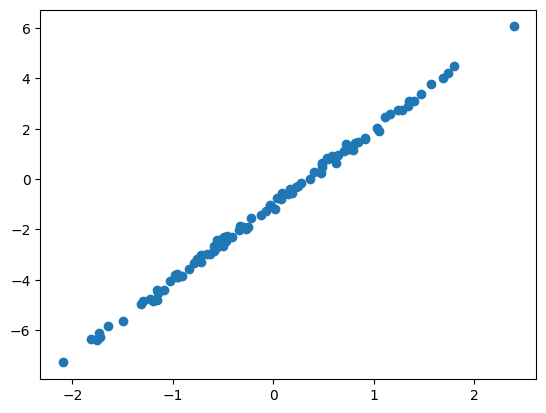

In [14]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys);

In [20]:
def model(theta, x):
    w, b = theta
    return w * x + b

def loss_fn(theta, x, y):
    prediction = model(theta, x)
    return jnp.mean((prediction-y)**2)

@jax.jit
def update(theta, x, y, lr=0.1):
    return theta - lr * jax.grad(loss_fn)(theta, x, y)

w: 3.00, b: -1.00


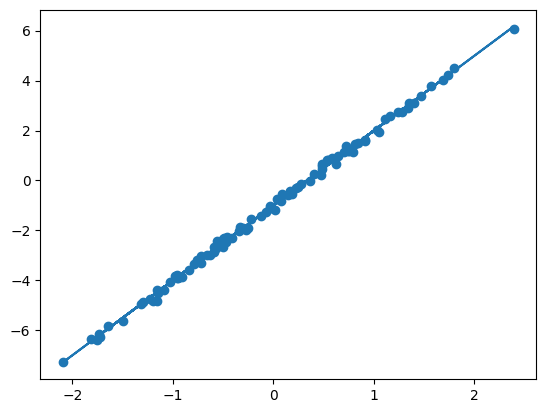

In [21]:
theta = jnp.array([1., 1.])

for _ in range(1000):
    theta = update(theta, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")

In [22]:
global_list = []

def log2(x):
    global_list.append(x)
    ln_x = jnp.log(x)
    ln_2 = jnp.log(2.0)
    return ln_x / ln_2

print(jax.make_jaxpr(log2)(3.0))

{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    d:f32[] = div b c
  in (d,) }


In [23]:
def log2_with_print(x):
    print("pinted x:", x)
    ln_x = jnp.log(x)
    ln_2 = jnp.log(2.0)
    return ln_x / ln_2

print(jax.make_jaxpr(log2_with_print)(3.))

pinted x: Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    d:f32[] = div b c
  in (d,) }


In [24]:
def log2_if_rank_2(x):
  if x.ndim == 2:
    ln_x = jnp.log(x)
    ln_2 = jnp.log(2.0)
    return ln_x / ln_2
  else:
    return x

print(jax.make_jaxpr(log2_if_rank_2)(jax.numpy.array([1, 2, 3])))

{ lambda ; a:i32[3]. let  in (a,) }


In [25]:
def selu(x, alpha=1.67, lambda_=1.05):
    return lambda_ * jnp.where(x>0, x, alpha*jnp.exp(x) - alpha)

x = jnp.arange(1_000_000)
%timeit selu(x).block_until_ready()

129 µs ± 3.03 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [26]:
selu_jit = jax.jit(selu)

selu_jit(x).block_until_ready()

%timeit selu_jit(x).block_until_ready

10.7 µs ± 109 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [30]:
def f(x):
  if x > 0:
    return x
  else:
    return 2 * x

def g(x, n):
  i = 0
  while i < n:
    i += 1
  return x + i

In [31]:
@jax.jit
def loop_body(prev_i):
  return prev_i + 1

def g_inner_jitted(x, n):
  i = 0
  while i < n:
    i = loop_body(i)
  return x + i

g_inner_jitted(10, 20)

Array(30, dtype=int32, weak_type=True)

In [32]:
f_jit_correct = jax.jit(f, static_argnums=0)
print(f_jit_correct(10))

g_jit_correct = jax.jit(g, static_argnames=['n'])
print(g_jit_correct(10, 20))

10
30


In [33]:
from functools import partial

@partial(jax.jit, static_argnames=['n'])
def g_jit_decorated(x, n):
    i = 0 
    while i < n:
        i += 1
    return x + i

In [36]:
print("g jitted:")
%timeit g_jit_correct(10, 20).block_until_ready()

print("g:")
%timeit g(10, 20)

g jitted:
23.7 µs ± 724 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
g:
190 ns ± 1.65 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [37]:
from functools import partial

def unjitted_loop_body(prev_i):
  return prev_i + 1

def g_inner_jitted_partial(x, n):
  i = 0
  while i < n:
    # Don't do this! each time the partial returns
    # a function with different hash
    i = jax.jit(partial(unjitted_loop_body))(i)
  return x + i

def g_inner_jitted_lambda(x, n):
  i = 0
  while i < n:
    # Don't do this!, lambda will also return
    # a function with a different hash
    i = jax.jit(lambda x: unjitted_loop_body(x))(i)
  return x + i

def g_inner_jitted_normal(x, n):
  i = 0
  while i < n:
    # this is OK, since JAX can find the
    # cached, compiled function
    i = jax.jit(unjitted_loop_body)(i)
  return x + i

print("jit called in a loop with partials:")
%timeit g_inner_jitted_partial(10, 20).block_until_ready()

print("jit called in a loop with lambdas:")
%timeit g_inner_jitted_lambda(10, 20).block_until_ready()

print("jit called in a loop with caching:")
%timeit g_inner_jitted_normal(10, 20).block_until_ready()

jit called in a loop with partials:
246 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
jit called in a loop with lambdas:
238 ms ± 4.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
jit called in a loop with caching:
2.31 ms ± 202 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
x = jnp.arange(5)
w = jnp.array([2., 3., 4.])

def convolve(x, w):
    output = []
    for i in range(1, len(x)-1):
        output.append(jnp.dot(x[i-1:i+2], w))
    return jnp.array(output)

convolve(x, w)

Array([11., 20., 29.], dtype=float32)

In [42]:
xs = jnp.stack([x,x])
ws = jnp.stack([w,w])

def manually_batched_convolve(xs, ws):
  output = []
  for i in range(xs.shape[0]):
    output.append(convolve(xs[i], ws[i]))
  return jnp.stack(output)

print("Manual Batched:")
print(manually_batched_convolve(xs, ws))

def manually_vectorized_convolve(xs, ws):
  output = []
  for i in range(1, xs.shape[-1] -1):
    output.append(jnp.sum(xs[:, i-1:i+2] * ws, axis=1))
  return jnp.stack(output, axis=1)

print("Manual Vectorized:")
print(manually_vectorized_convolve(xs, ws))

Manual Batched:
[[11. 20. 29.]
 [11. 20. 29.]]
Manual Vectorized:
[[11. 20. 29.]
 [11. 20. 29.]]


In [43]:
auto_batch_convolve = jax.vmap(convolve)
auto_batch_convolve(xs, ws)

Array([[11., 20., 29.],
       [11., 20., 29.]], dtype=float32)

In [44]:
auto_batch_convolve_v2 = jax.vmap(convolve, in_axes=1, out_axes=1)

xst = jnp.transpose(xs)
wst = jnp.transpose(ws)

auto_batch_convolve_v2(xst, wst)

Array([[11., 11.],
       [20., 20.],
       [29., 29.]], dtype=float32)

In [45]:
batch_convolve_v3 = jax.vmap(convolve, in_axes=[0, None])

batch_convolve_v3(xs, w)

Array([[11., 20., 29.],
       [11., 20., 29.]], dtype=float32)

In [46]:
jitted_batch_convolve = jax.jit(auto_batch_convolve)

jitted_batch_convolve(xs, ws)

Array([[11., 20., 29.],
       [11., 20., 29.]], dtype=float32)

In [50]:
f = lambda x: x**3 + 2*x**2 - 3*x + 1

dfdx = jax.grad(f)
d2fdx = jax.grad(dfdx)
d3fdx = jax.grad(d2fdx)
d4fdx = jax.grad(d3fdx)

print(dfdx(1.))
print(d2fdx(1.))
print(d3fdx(1.))
print(d4fdx(1.))

4.0
10.0
6.0
0.0


In [51]:
def hessian(f):
  return jax.jacfwd(jax.grad(f))

In [52]:
def f(x):
  return jnp.dot(x, x)

hessian(f)(jnp.array([1., 2., 3.]))

Array([[2., 0., 0.],
       [0., 2., 0.],
       [0., 0., 2.]], dtype=float32)

In [53]:
import numpy as np
np.random.seed(0)

def print_truncated_random_state():
  """To avoid spamming the outputs, print only part of the state."""
  full_random_state = np.random.get_state()
  print(str(full_random_state)[:460], '...')

print_truncated_random_state()

('MT19937', array([         0,          1, 1812433255, 1900727105, 1208447044,
       2481403966, 4042607538,  337614300, 3232553940, 1018809052,
       3202401494, 1775180719, 3192392114,  594215549,  184016991,
        829906058,  610491522, 3879932251, 3139825610,  297902587,
       4075895579, 2943625357, 3530655617, 1423771745, 2135928312,
       2891506774, 1066338622,  135451537,  933040465, 2759011858,
       2273819758, 3545703099, 2516396728, 127 ...


In [54]:
np.random.seed(0)

print_truncated_random_state()

_ = np.random.uniform()

print_truncated_random_state()

('MT19937', array([         0,          1, 1812433255, 1900727105, 1208447044,
       2481403966, 4042607538,  337614300, 3232553940, 1018809052,
       3202401494, 1775180719, 3192392114,  594215549,  184016991,
        829906058,  610491522, 3879932251, 3139825610,  297902587,
       4075895579, 2943625357, 3530655617, 1423771745, 2135928312,
       2891506774, 1066338622,  135451537,  933040465, 2759011858,
       2273819758, 3545703099, 2516396728, 127 ...
('MT19937', array([2443250962, 1093594115, 1878467924, 2709361018, 1101979660,
       3904844661,  676747479, 2085143622, 1056793272, 3812477442,
       2168787041,  275552121, 2696932952, 3432054210, 1657102335,
       3518946594,  962584079, 1051271004, 3806145045, 1414436097,
       2032348584, 1661738718, 1116708477, 2562755208, 3176189976,
        696824676, 2399811678, 3992505346,  569184356, 2626558620,
        136797809, 4273176064,  296167901, 343 ...


In [55]:
np.random.seed(0)
print("individually:", np.stack([np.random.uniform() for _ in range(3)]))

np.random.seed(0)
print("all at once: ", np.random.uniform(size=3))


individually: [0.5488135  0.71518937 0.60276338]
all at once:  [0.5488135  0.71518937 0.60276338]


In [56]:
np.random.seed(0)

def bar(): return np.random.uniform()
def baz(): return np.random.uniform()

def foo(): return bar() + 2 * baz()

print(foo())

1.9791922366721637


In [57]:
from jax import random

key = random.PRNGKey(42)

print(key)

[ 0 42]


In [58]:
print("old key", key)
new_key, subkey = random.split(key)
del key  # The old key is discarded -- we must never use it again.
normal_sample = random.normal(subkey)
print(r"    \---SPLIT --> new key   ", new_key)
print(r"             \--> new subkey", subkey, "--> normal", normal_sample)
del subkey  # The subkey is also discarded after use.

# Note: you don't actually need to `del` keys -- that's just for emphasis.
# Not reusing the same values is enough.

key = new_key  # If we wanted to do this again, we would use new_key as the key.

old key [ 0 42]
    \---SPLIT --> new key    [2465931498 3679230171]
             \--> new subkey [255383827 267815257] --> normal 1.3694694


In [59]:
key = random.PRNGKey(42)
subkeys = random.split(key, 3)
sequence = np.stack([random.normal(subkey) for subkey in subkeys])
print("individually:", sequence)

key = random.PRNGKey(42)
print("all at once: ", random.normal(key, shape=(3,)))

individually: [-0.04838832  0.10796154 -1.2226542 ]
all at once:  [ 0.18693547 -1.2806505  -1.5593132 ]


In [60]:
def init_mlp_params(layer_widths):
  params = []
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
             biases=np.ones(shape=(n_out,))
            )
    )
  return params

params = init_mlp_params([1, 128, 128, 1])

In [61]:
jax.tree_map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [64]:
def forward(params, x):
    *hidden, last = params
    for layer in hidden:
        x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
    return x @ last['weights'] + last['biases']

LR = 1e-4

def loss_fn(params, x, y):
    return jnp.mean((forward(params, x) - y) ** 2)

@jax.jit
def update(params, x, y):
    grads = jax.grad(loss_fn)(params, x, y)
    return jax.tree_map(lambda p,g: p - LR * g, params, grads)

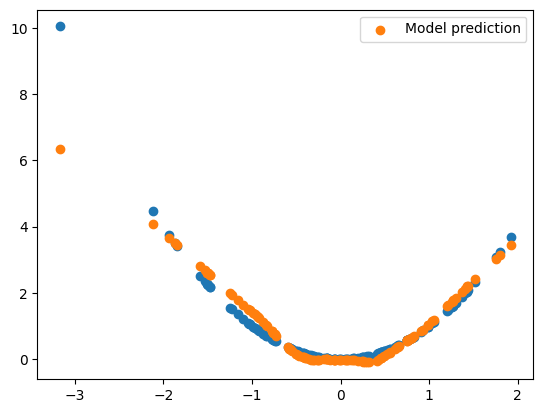

In [65]:
xs = np.random.normal(size=(128, 1))
ys = xs ** 2

for _ in range(1000):
    params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend();

In [67]:
import collections

ATuple = collections.namedtuple("ATuple", ('name'))

tree = [1, {'k1': 2, 'k2': (3, 4)}, ATuple('foo')]
flattened, _ = jax.tree_util.tree_flatten_with_path(tree)
for key_path, value in flattened:
    print(f'Value of tree{jax.tree_util.keystr(key_path)}: {value}')

Value of tree[0]: 1
Value of tree[1]['k1']: 2
Value of tree[1]['k2'][0]: 3
Value of tree[1]['k2'][1]: 4
Value of tree[2].name: foo


In [68]:
class MyContainer:
  """A named container."""

  def __init__(self, name: str, a: int, b: int, c: int):
    self.name = name
    self.a = a
    self.b = b
    self.c = c

In [70]:
jax.tree_util.tree_leaves([
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6)
])


TypeError: unsupported operand type(s) for +: 'MyContainer' and 'int'


In [71]:
try:
    jax.tree_map(lambda x: x + 1, [
        MyContainer('Alice', 1, 2, 3),
        MyContainer('Bob', 4, 5, 6)
    ])
except TypeError as e:
    print(f'TypeError: {e}')

TypeError: unsupported operand type(s) for +: 'MyContainer' and 'int'


In [73]:
from typing import Iterable

def flatten_MyContainer(container) -> tuple[Iterable[int], str]:
  """Returns an iterable over container contents, and aux data."""
  flat_contents = [container.a, container.b, container.c]

  # we don't want the name to appear as a child, so it is auxiliary data.
  # auxiliary data is usually a description of the structure of a node,
  # e.g., the keys of a dict -- anything that isn't a node's children.
  aux_data = container.name
  return flat_contents, aux_data

def unflatten_MyContainer(
    aux_data: str, flat_contents: Iterable[int]) -> MyContainer:
  """Converts aux data and the flat contents into a MyContainer."""
  return MyContainer(aux_data, *flat_contents)

jax.tree_util.register_pytree_node(
    MyContainer, flatten_MyContainer, unflatten_MyContainer)

jax.tree_util.tree_leaves([
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6)
])

[1, 2, 3, 4, 5, 6]

In [74]:
class MyKeyPathContainer(MyContainer):
  pass

def flatten_with_keys_MyKeyPathContainer(container) -> tuple[Iterable[int], str]:
  """Returns an iterable over container contents, and aux data."""

  # GetAttrKey is a common way to express an attribute key. Users are free
  # to pick any other expression that fits their use cases the best.
  flat_contents = [(jax.tree_util.GetAttrKey('a'), container.a),
                   (jax.tree_util.GetAttrKey('b'), container.b),
                   (jax.tree_util.GetAttrKey('c'), container.c)]

  # we don't want the name to appear as a child, so it is auxiliary data.
  # auxiliary data is usually a description of the structure of a node,
  # e.g., the keys of a dict -- anything that isn't a node's children.
  aux_data = container.name
  return flat_contents, aux_data

def unflatten_MyKeyPathContainer(
    aux_data: str, flat_contents: Iterable[int]) -> MyKeyPathContainer:
  """Converts aux data and the flat contents into a MyContainer."""
  return MyKeyPathContainer(aux_data, *flat_contents)

jax.tree_util.register_pytree_with_keys(
    MyKeyPathContainer, flatten_with_keys_MyKeyPathContainer, unflatten_MyKeyPathContainer)

jax.tree_util.tree_leaves([
    MyKeyPathContainer('Alice', 1, 2, 3),
    MyKeyPathContainer('Bob', 4, 5, 6)
])

[1, 2, 3, 4, 5, 6]

In [75]:
flattened, _ = jax.tree_util.tree_flatten_with_path(MyContainer('Alice', 1, 2, 3))
for key_path, value in flattened:
    print(f'MyContainer container{jax.tree_util.keystr(key_path)}: {value}')

flattened, _ = jax.tree_util.tree_flatten_with_path(MyKeyPathContainer('Alice', 1, 2, 3))
for key_path, value in flattened:
    print(f'MyKeyPathContainer container{jax.tree_util.keystr(key_path)}: {value}')

MyContainer container[<flat index 0>]: 1
MyContainer container[<flat index 1>]: 2
MyContainer container[<flat index 2>]: 3
MyKeyPathContainer container.a: 1
MyKeyPathContainer container.b: 2
MyKeyPathContainer container.c: 3


In [76]:
from typing import NamedTuple, Any

class MyOtherContainer(NamedTuple):
  name: str
  a: Any
  b: Any
  c: Any

# NamedTuple subclasses are handled as pytree nodes, so
# this will work out-of-the-box:
jax.tree_util.tree_leaves([
    MyOtherContainer('Alice', 1, 2, 3),
    MyOtherContainer('Bob', 4, 5, 6)
])

['Alice', 1, 2, 3, 'Bob', 4, 5, 6]

In [77]:
from typing import NamedTuple, Any

@jax.tree_util.register_static
class StaticStr(str):
  pass


class YetAnotherContainer(NamedTuple):
  name: StaticStr
  a: Any
  b: Any
  c: Any


# NamedTuple subclasses are handled as pytree nodes, so
# this will work out-of-the-box:
jax.tree_util.tree_leaves([
    YetAnotherContainer(StaticStr('Alice'), 1, 2, 3),
    YetAnotherContainer(StaticStr('Bob'), 4, 5, 6)
])

[1, 2, 3, 4, 5, 6]

In [78]:
jax.devices()

[cuda(id=0)]

In [80]:
x = np.arange(5)
w = np.array([2., 3., 4.])

def convolve(x, w):
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

convolve(x, w)

Array([11., 20., 29.], dtype=float32)

In [82]:
n_devices = jax.local_device_count() 
xs = np.arange(5 * n_devices).reshape(-1, 5)
ws = np.stack([w] * n_devices)

xs, ws

(array([[0, 1, 2, 3, 4]]), array([[2., 3., 4.]]))

In [83]:
jax.vmap(convolve)(xs, ws)

Array([[11., 20., 29.]], dtype=float32)

In [84]:
jax.pmap(convolve)(xs, ws)

Array([[11., 20., 29.]], dtype=float32)

In [85]:
jax.pmap(convolve)(xs, jax.pmap(convolve)(xs, ws))

Array([[ 78., 138., 198.]], dtype=float32)

In [86]:
jax.pmap(convolve, in_axes=(0, None))(xs, w)

Array([[11., 20., 29.]], dtype=float32)

In [87]:
from typing import NamedTuple

class Params(NamedTuple):
  weight: jnp.ndarray
  bias: jnp.ndarray


def init(rng) -> Params:
  """Returns the initial model params."""
  weights_key, bias_key = jax.random.split(rng)
  weight = jax.random.normal(weights_key, ())
  bias = jax.random.normal(bias_key, ())
  return Params(weight, bias)


def loss(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
  """Computes the least squares error of the model's predictions on x against y."""
  pred = params.weight * x + params.bias
  return jnp.mean((pred - y) ** 2)


LEARNING_RATE = 0.005

@jax.jit
def update(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> Params:
  """Performs one SGD update step on params using the given data."""
  grad = jax.grad(loss)(params, x, y)

  # If we were using Adam or another stateful optimizer,
  # we would also do something like
  # ```
  # updates, new_optimizer_state = optimizer(grad, optimizer_state)
  # ```
  # and then use `updates` instead of `grad` to actually update the params.
  # (And we'd include `new_optimizer_state` in the output, naturally.)

  new_params = jax.tree_map(
      lambda param, g: param - g * LEARNING_RATE, params, grad)

  return new_params

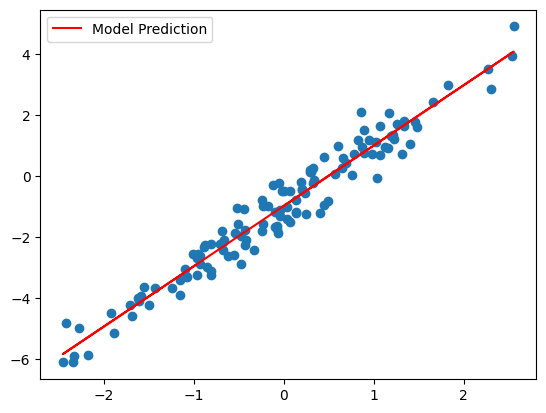

In [88]:
import matplotlib.pyplot as plt

rng = jax.random.PRNGKey(42)

# Generate true data from y = w*x + b + noise
true_w, true_b = 2, -1
x_rng, noise_rng = jax.random.split(rng)
xs = jax.random.normal(x_rng, (128, 1))
noise = jax.random.normal(noise_rng, (128, 1)) * 0.5
ys = xs * true_w + true_b + noise

# Fit regression
params = init(rng)
for _ in range(1000):
  params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, params.weight * xs + params.bias, c='red', label='Model Prediction')
plt.legend();